In [1]:
import rasterio
from rasterio import plot
import numpy as np
import importlib

import matplotlib.pyplot as plt


import datacube
import xarray as xr

import tensorflow as tf


%matplotlib inline

/home/datacube/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/datacube/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/datacube/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/datacube/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
print(tf.__version__)

1.14.0


## For viewing the training dataset with lables

Select a tile and run the next cells

In [3]:
from rasterio.plot import show
import json

In [4]:
# S2B_MSIL2A_20171206T094349_63_85 ejemplo de agricultura
# S2A_MSIL2A_20170816T095031_43_64 : Non-irrigated arable land, Fruit trees and berry plantations, Pastures, Complex cultivation patterns
# S2A_MSIL2A_20170816T095031_37_71 : Pastures, Land principally occupied by agriculture, with significant areas of natural vegetation, Water courses

tile = 'S2A_MSIL2A_20170816T095031_37_71'

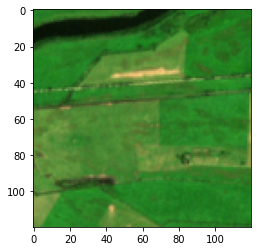

In [5]:
raster_B02 = rasterio.open("/analysis_storage/TrainingDataset/BigEarthNet-v1.0/"+tile+"/"+tile+"_B02.tif")
raster_B03 = rasterio.open("/analysis_storage/TrainingDataset/BigEarthNet-v1.0/"+tile+"/"+tile+"_B03.tif")
raster_B04 = rasterio.open("/analysis_storage/TrainingDataset/BigEarthNet-v1.0/"+tile+"/"+tile+"_B04.tif")


b2 = raster_B02.read(1)
b3 = raster_B03.read(1)
b4 = raster_B04.read(1)

rgb = np.dstack([b4,b3,b2])

rgb = plot.adjust_band(rgb)
    
plt.imshow(rgb)

In [6]:
handle = open("/analysis_storage/TrainingDataset/BigEarthNet-v1.0/"+tile+"/"+tile+"_labels_metadata.json", 'r')       
loaded_json = json.load(handle)
print(json.dumps(loaded_json, indent=4, sort_keys=False))
handle.close()

# To see the projection of the points in lat lon format check https://epsg.io/transform#s_srs=32634&t_srs=4326&x=544380.0000000&y=6114840.0000000

{
    "labels": [
        "Pastures",
        "Land principally occupied by agriculture, with significant areas of natural vegetation",
        "Water courses"
    ],
    "coordinates": {
        "ulx": 544380,
        "uly": 6114840,
        "lrx": 545580,
        "lry": 6113640
    },
    "projection": "PROJCS[\"WGS 84 / UTM zone 34N\",GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AXIS[\"Latitude\",NORTH],AXIS[\"Longitude\",EAST],AUTHORITY[\"EPSG\",\"4326\"]],PROJECTION[\"Transverse_Mercator\"],PARAMETER[\"latitude_of_origin\",0],PARAMETER[\"central_meridian\",21],PARAMETER[\"scale_factor\",0.9996],PARAMETER[\"false_easting\",500000],PARAMETER[\"false_northing\",0],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]],AXIS[\"Easting\",EAST],AXIS[\"Northing\",NORTH],AUTHORITY[\"EPSG\"

# Load the model

In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('/analysis_storage/bigearthnet-models-tf/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import get_metrics


In [8]:
#with tf.Session() as sess:
sess = tf.Session()
model = importlib.import_module('models.ResNet50').DNN_model('original')
model.create_network()


In [9]:
variables_to_restore = tf.global_variables()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [10]:
saver = tf.train.import_meta_graph("/analysis_storage/bigearthnet-models-tf/model_weights/original_labels/ResNet50/ResNet50_BigEarthNet_original_labels.meta")
saver.restore(sess, "/analysis_storage/bigearthnet-models-tf/model_weights/original_labels/ResNet50/ResNet50_BigEarthNet_original_labels")

'metric_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /analysis_storage/bigearthnet-models-tf/model_weights/original_labels/ResNet50/ResNet50_BigEarthNet_original_labels


# Load the data from the datacube

In [11]:
# Set the data source - s2a corresponds to Sentinel-2A
set_product = "s2_sen2cor_ard_granule_EO3"

# Set the date range to load data over
set_time = ("2020-08-01", "2020-08-02")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
set_measurements = [
#     "red",
#     "blue",
#     "green",
#     "nir"
#     'B01_60m',
    'B02_10m',
    'B03_10m',
    'B04_10m', 
#     'B05_20m',
#     'B06_20m',
#     'B07_20m',
    'B08_10m',
#     'B8A_20m',
#     'B09_60m',
#     'B11_20m',
#     'B12_20m'
]

study_area_lat = (10659308.545576254,10659750.405602872)
study_area_lon = (-4012.7939393850393,-3768.136839356972)

# Set the coordinate reference system and output resolution
# set_crs = 'EPSG:32719'
set_crs = 'EPSG:32719'

set_resolution = (-10, 10)

set_resampling = 'cubic'

In [12]:
dc = datacube.Datacube(app='Predictions')
dataset_10 = dc.load(
    product=set_product,
    longitude=study_area_lon,
    latitude=study_area_lat,
    time=set_time,
    measurements=set_measurements,
    crs=set_crs,
    output_crs=set_crs,
    resolution=set_resolution,
)
dataset_10

<xarray.Dataset>
Dimensions:      (time: 1, x: 26, y: 46)
Coordinates:
  * time         (time) datetime64[ns] 2020-08-01T20:56:40
  * y            (y) float64 1.066e+07 1.066e+07 ... 1.066e+07 1.066e+07
  * x            (x) float64 -4.015e+03 -4.005e+03 ... -3.775e+03 -3.765e+03
    spatial_ref  int32 32719
Data variables:
    B02_10m      (time, y, x) uint16 224 222 241 172 117 ... 157 234 474 571 534
    B03_10m      (time, y, x) uint16 459 463 469 397 286 ... 321 404 727 835 767
    B04_10m      (time, y, x) uint16 302 297 318 248 168 ... 410 938 1144 1015
    B08_10m      (time, y, x) uint16 2644 2551 2530 1992 ... 2380 2056 2122 2120
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

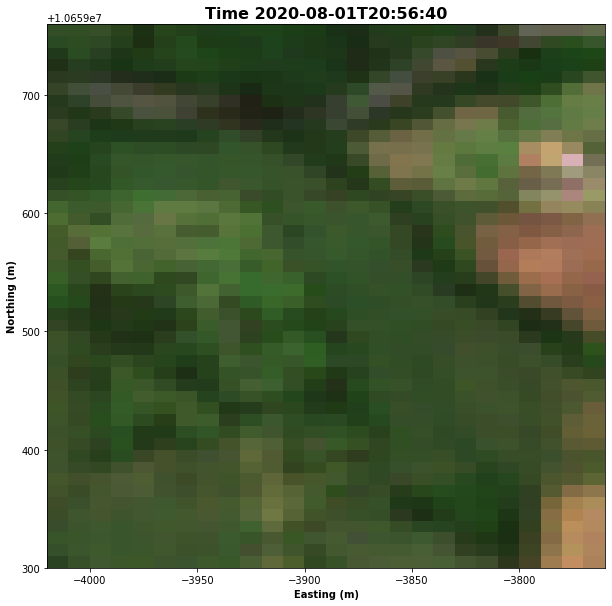

In [13]:
# Set the time step to view
time_index = 0

# Set the band combination to plot
bands = ['B04_10m', 'B03_10m','B02_10m']
# bands = [ "blue","green","red"]

# Format the time stamp for use as the plot title
time_string = str(dataset_10.time.isel(time=time_index).values).split('.')[0]  

dataset_10[bands].isel(time=time_index).to_array().plot.imshow(vmin=0,vmax=1500,figsize=(10,10))

# Set the title and axis labels
ax = plt.gca()

ax.set_title(f"Time {time_string}", fontweight='bold', fontsize=16)
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold')

# Display the plot
plt.show()

In [14]:
# Set the data source - s2a corresponds to Sentinel-2A
set_product = "s2_sen2cor_ard_granule_EO3"

# Set the date range to load data over
set_time = ("2020-08-01", "2020-08-02")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
set_measurements = [
#     "red",
#     "blue",
#     "green",
#     "nir"
#     'B01_60m',
#     'B02_10m',
#     'B03_10m',
#     'B04_10m', 
    'B05_20m',
    'B06_20m',
    'B07_20m',
#     'B08_10m',
    'B8A_20m',
#     'B09_60m',
    'B11_20m',
    'B12_20m'
]

study_area_lat = (10659308.545576254,10659750.405602872)
study_area_lon = (-4012.7939393850393,-3768.136839356972)

# Set the coordinate reference system and output resolution
# set_crs = 'EPSG:32719'
set_crs = 'EPSG:32719'

set_resolution = (-20, 20)

set_resampling = 'cubic'

In [15]:
dc = datacube.Datacube(app='Predictions')
dataset_20 = dc.load(
    product=set_product,
    longitude=study_area_lon,
    latitude=study_area_lat,
    time=set_time,
    measurements=set_measurements,
    crs=set_crs,
    output_crs=set_crs,
    resolution=set_resolution,
)
dataset_20

<xarray.Dataset>
Dimensions:      (time: 1, x: 13, y: 23)
Coordinates:
  * time         (time) datetime64[ns] 2020-08-01T20:56:40
  * y            (y) float64 1.066e+07 1.066e+07 ... 1.066e+07 1.066e+07
  * x            (x) float64 -4.01e+03 -3.99e+03 ... -3.79e+03 -3.77e+03
    spatial_ref  int32 32719
Data variables:
    B05_20m      (time, y, x) uint16 724 649 564 662 667 ... 780 647 977 1322
    B06_20m      (time, y, x) uint16 2034 1721 1917 2245 ... 1977 1813 1732 1778
    B07_20m      (time, y, x) uint16 2474 2168 2481 2796 ... 2339 2278 2060 2000
    B8A_20m      (time, y, x) uint16 2802 2314 2763 3064 ... 2580 2539 2362 2232
    B11_20m      (time, y, x) uint16 1398 1340 1332 1440 ... 1693 1578 2548 3333
    B12_20m      (time, y, x) uint16 671 653 629 621 601 ... 975 852 1643 2392
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [16]:
# Set the data source - s2a corresponds to Sentinel-2A
set_product = "s2_sen2cor_ard_granule_EO3"

# Set the date range to load data over
set_time = ("2020-08-01", "2020-08-02")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
set_measurements = [
#     "red",
#     "blue",
#     "green",
#     "nir"
    'B01_60m',
#     'B02_10m',
#     'B03_10m',
#     'B04_10m', 
#     'B05_20m',
#     'B06_20m',
#     'B07_20m',
#     'B08_10m',
#     'B8A_20m',
    'B09_60m',
#     'B11_20m',
#     'B12_20m'
]

study_area_lat = (10659308.545576254,10659750.405602872)
study_area_lon = (-4012.7939393850393,-3768.136839356972)

# Set the coordinate reference system and output resolution
# set_crs = 'EPSG:32719'
set_crs = 'EPSG:32719'

set_resolution = (-60, 60)

set_resampling = 'cubic'

In [17]:
dc = datacube.Datacube(app='Predictions')
dataset_60 = dc.load(
    product=set_product,
    longitude=study_area_lon,
    latitude=study_area_lat,
    time=set_time,
    measurements=set_measurements,
    crs=set_crs,
    output_crs=set_crs,
    resolution=set_resolution,
)
dataset_60

<xarray.Dataset>
Dimensions:      (time: 1, x: 5, y: 8)
Coordinates:
  * time         (time) datetime64[ns] 2020-08-01T20:56:40
  * y            (y) float64 1.066e+07 1.066e+07 ... 1.066e+07 1.066e+07
  * x            (x) float64 -3.99e+03 -3.93e+03 -3.87e+03 -3.81e+03 -3.75e+03
    spatial_ref  int32 32719
Data variables:
    B01_60m      (time, y, x) uint16 97 68 103 134 160 ... 134 142 141 181 234
    B09_60m      (time, y, x) uint16 2461 2833 2558 2277 ... 2680 2719 2487 2200
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [18]:
dic = {}
dic['B01'] = dataset_60.B01_60m.values
dic['B02'] = dataset_10.B02_10m.values
dic['B03'] = dataset_10.B03_10m.values
dic['B04'] = dataset_10.B04_10m.values
dic['B05'] = dataset_20.B05_20m.values
dic['B06'] = dataset_20.B06_20m.values
dic['B07'] = dataset_20.B07_20m.values
dic['B07'] = dataset_20.B07_20m.values
dic['B08'] = dataset_10.B08_10m.values
dic['B8A'] = dataset_20.B8A_20m.values
dic['B09'] = dataset_60.B09_60m.values
dic['B11'] = dataset_20.B11_20m.values
dic['B12'] = dataset_20.B12_20m.values
dic['original_labels_multi_hot'] = np.zeros((1, 43), dtype=int)

# Padding the data so the model can read from it

In [19]:
dic['B01'] = np.pad(dic['B01'], ((0, 0),(6, 6),(7, 8)) )
dic['B02'] = np.pad(dic['B02'], ((0, 0),(37, 37),(47, 47)) )
dic['B03'] = np.pad(dic['B03'], ((0, 0),(37, 37),(47, 47)) )
dic['B04'] = np.pad(dic['B04'], ((0, 0),(37, 37),(47, 47)) )
dic['B05'] = np.pad(dic['B05'], ((0, 0),(18, 19),(23, 24)) )
dic['B06'] = np.pad(dic['B06'], ((0, 0),(18, 19),(23, 24)) )
dic['B07'] = np.pad(dic['B07'], ((0, 0),(18, 19),(23, 24)) )
dic['B08'] = np.pad(dic['B08'], ((0, 0),(37, 37),(47, 47)) )
dic['B8A'] = np.pad(dic['B8A'], ((0, 0),(18, 19),(23, 24)) )
dic['B09'] = np.pad(dic['B09'], ((0, 0),(6, 6),(7, 8)) )
dic['B11'] = np.pad(dic['B11'], ((0, 0),(18, 19),(23, 24)) )
dic['B12'] = np.pad(dic['B12'], ((0, 0),(18, 19),(23, 24)) )

In [20]:
sess_res = sess.run(model.predictions, feed_dict=model.feed_dict(dic))

In [21]:
 original_labels = [
        "Continuous urban fabric",
        "Discontinuous urban fabric",
        "Industrial or commercial units",
        "Road and rail networks and associated land",
        "Port areas",
        "Airports",
        "Mineral extraction sites",
        "Dump sites",
        "Construction sites",
        "Green urban areas",
        "Sport and leisure facilities",
        "Non-irrigated arable land",
        "Permanently irrigated land",
        "Rice fields",
        "Vineyards",
        "Fruit trees and berry plantations",
        "Olive groves",
        "Pastures",
        "Annual crops associated with permanent crops",
        "Complex cultivation patterns",
        "Land principally occupied by agriculture, with significant areas of natural vegetation",
        "Agro-forestry areas",
        "Broad-leaved forest",
        "Coniferous forest",
        "Mixed forest",
        "Natural grassland",
        "Moors and heathland",
        "Sclerophyllous vegetation",
        "Transitional woodland/shrub",
        "Beaches, dunes, sands",
        "Bare rock",
        "Sparsely vegetated areas",
        "Burnt areas",
        "Inland marshes",
        "Peatbogs",
        "Salt marshes",
        "Salines",
        "Intertidal flats",
        "Water courses",
        "Water bodies",
        "Coastal lagoons",
        "Estuaries",
        "Sea and ocean"
 ]


In [22]:
sess_res

array([[1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.]], dtype=float32)

In [23]:
sess.close()

In [24]:
sess_res[0][1]

0.0

In [25]:
for i in range(43):
    if sess_res[0][i]:
        print(original_labels[i]) 

Continuous urban fabric
Industrial or commercial units
Dump sites
Construction sites
Non-irrigated arable land
Permanently irrigated land
Rice fields
Vineyards
Pastures
Complex cultivation patterns
Agro-forestry areas
Coniferous forest
Moors and heathland
Transitional woodland/shrub
Sparsely vegetated areas
Inland marshes
Water courses
Water bodies
Estuaries
